# Demo for coffee learning 0908

### 1. 引入相關套件

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

### 2. 讀取檔案

In [2]:
data_dir = "./coffee_data.xlsx"
df = pd.read_excel(data_dir)

### 3. 稍微確認一下資料的形式

In [3]:
df.shape

(300, 904)

In [4]:
df.head()

,豆子種類,Scan file,Agtron III_G,Sample Number,700,702,704,706,708,710,...,2480,2482,2484,2486,2488,2490,2492,2494,2496,2498
0,Arabica,A25G_w1,24.3,A25G_w1,1.009872,1.005166,1.000456,0.995730,0.990981,0.986239,...,0.998750,1.004919,1.010784,1.016384,1.021699,1.026701,1.031699,1.036464,1.040877,1.045308
1,Arabica,A30G_w1,30.1,A30G_w1,0.841986,0.837227,0.832504,0.827815,0.823142,0.818491,...,0.797958,0.802303,0.806244,0.810356,0.814289,0.818135,0.821907,0.825504,0.828727,0.831796
2,Arabica,A35G_w1,34.8,A35G_w1,0.772427,0.767935,0.763465,0.759012,0.754586,0.750181,...,0.798422,0.802911,0.806890,0.811073,0.815109,0.819081,0.822929,0.826484,0.829827,0.833088
3,Arabica,A40G_w1,40.8,A40G_w1,0.738502,0.734085,0.729687,0.725311,0.720965,0.716644,...,0.784862,0.789221,0.793779,0.797882,0.801580,0.805487,0.809205,0.812715,0.816128,0.819209
4,Arabica,A45G_w1,44.6,A45G_w1,0.689163,0.684965,0.680791,0.676638,0.672506,0.668398,...,0.804665,0.808950,0.813117,0.817304,0.821281,0.825327,0.829113,0.832572,0.835892,0.839078


Text(0.5, 1.0, 'sample name: R70G_w2')

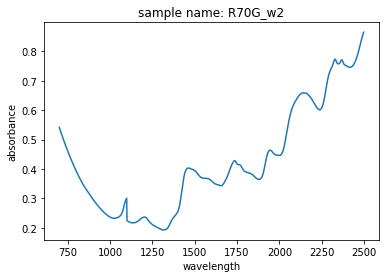

In [5]:
wave = list(range(700, 2500, 2))
random_spectrum = df.iloc[87, -900:]
plt.plot(wave, random_spectrum)
plt.xlabel('wavelength')
plt.ylabel('absorbance')
plt.title(f'sample name: {df.iloc[87, 3]}')

### 3. 資料集的準備
#### - 一般訓練模型時，為了避免過擬和(overfitting)的狀況、增強模型的穩健性...等等考量
#### - 資料會切成訓練集(training set)、驗證集(validation set)及測試集(testing set)
#### - 驗證集的角色類似於測試集，只是它不會影響模型的訓練過程，它只是作為測試模型效能之用途
#### - 驗證集的切分方法很多，有 n-folder spliting、leave-one-out...

In [6]:
train_spectra, test_spectra = df.iloc[:150, -900:], df.iloc[250:, -900:]
train_agtron, test_agtron = df.iloc[:150, 2], df.iloc[250:, 2]

### 4. 光譜前處理的準備

In [7]:
def MSC(input_spectrum, reference = None):
    for i in range(input_spectrum.shape[0]):
        input_spectrum[i, :] -= input_spectrum[i, :].mean()
    if reference is None:
        ref = np.mean(input_spectrum, axis = 0)
    else:
        ref = reference
    msc_spectrum = np.zeros_like(input_spectrum)
    for i in range(input_spectrum.shape[0]):
        fit = np.polyfit(ref, input_spectrum[i, :], 1, full = True)
        msc_spectrum[i, :] = (input_spectrum[i, :] - fit[0][1]) / fit[0][0]

    return (msc_spectrum, ref)

In [8]:
from scipy.signal import savgol_filter

def SG(input_spectrum, arguments):
    #the function is the correction of the NIR data
    #input data is a samples * one dimension  feature data
    #savitzky golay filter
    def _decode_argument(arguments):
        arguments = arguments.split('_')
        poly, der, win = 0, 0, 1
        for obj in arguments:
            if 'help' in obj:
                print('There were three arguments can be set in SG filter, [poly_order, derivative order, window length].')
                print('All of the arguments must be a int. Here is example: SG_w5_p2_d2')
                exit(0)
            else:
                if 'p' in obj:
                    poly = int(obj.replace('p', ''))
                elif 'd' in obj:
                    der = int(obj.replace('d', ''))
                elif 'w' in obj:
                    temp = int(obj.replace('w', ''))
                    if temp % 2 == 0 or temp < 0:
                        raise ValueError('window length of SG filter must be a positive and odd number.')
                    else:
                        win = temp
        if poly >= win:
            raise ValueError('polyorder must be less than window_length.')

        if der < 0:
            raise ValueError('This must be a nonnegative integer.')

        return poly, der, win

    poly, der, win = _decode_argument(arguments)

    for i in range(input_spectrum.shape[0]):
        input_spectrum[i] = savgol_filter(input_spectrum[i], window_length = win, polyorder = poly, deriv = der)

    if win == 1:
        adjust_length = 0
    else:
        adjust_length = win // 2

    if adjust_length > 0:
        input_spectrum[:, -adjust_length:] = 0.0
        input_spectrum[:, 0: adjust_length] = 0.0

    return input_spectrum

In [9]:
(train_spectra_msc, _), (test_spectra_msc, _) = MSC(train_spectra.values), MSC(test_spectra.values)

In [10]:
train_spectra_msc_sg, test_spectra_msc_sg = SG(train_spectra_msc, 'SG_w5_p2_d1'), SG(test_spectra_msc, 'SG_w5_p2_d1')

### 5. 模型建立、參數選定、訓練 GO

In [11]:
num_components = 5
plsr = PLSRegression(n_components = num_components)
plsr.fit(train_spectra, train_agtron)
output = plsr.predict(test_spectra)

In [12]:
plsr_msc_sg = PLSRegression(n_components = num_components)
plsr_msc_sg.fit(train_spectra_msc_sg, train_agtron)
output_msc_sg = plsr_msc_sg.predict(test_spectra_msc_sg)

### 6. 衡量指標

In [13]:
def rmse(output, target):
    return np.around(np.sum((output - target) ** 2) / output.shape[0], 3)

def r2(output, target):
    return round(r2_score(output, target), 3)

def rpd(output, target):
    bias = np.sum(np.subtract(output, target), axis = 0) / output.shape[0]
    sep = ((np.sum(np.subtract(np.subtract(output, target), bias) ** 2, axis = 0)) / (output.shape[0] - 1)) ** 0.5
    return np.around(np.std(target, axis = 0) / sep, 3)

In [14]:
print(f'RMSE: w/o pretreatment: {rmse(output.flatten(), test_agtron)},\
    w/ pretreatment:{rmse(output_msc_sg.flatten(), test_agtron)}')

print(f'R-square: w/o pretreatment: {r2(output.flatten(), test_agtron)},\
    w/ pretreatment:{r2(output_msc_sg.flatten(), test_agtron)}')

print(f'RPD: w/o pretreatment: {rpd(output.flatten(), test_agtron)},\
    w/ pretreatment:{rpd(output_msc_sg.flatten(), test_agtron)}')

RMSE: w/o pretreatment: 5.105,    w/ pretreatment:34.64
R-square: w/o pretreatment: 0.967,    w/ pretreatment:0.745
RPD: w/o pretreatment: 5.743,    w/ pretreatment:2.586


### 7. 實戰演練~